1. Function to sample images with a moving window
2. Function to and align stack images

In [135]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from skimage import io
import time
import tensorflow as tf
from sklearn.cluster import KMeans
import pickle
import imutils

In [15]:
# load image
test_path = 'Images/ppltest.jpg'
img_test = plt.imread(test_path)
print(img_test.shape)

(1745, 1014, 4)


Images are loaded in with RGB color paths

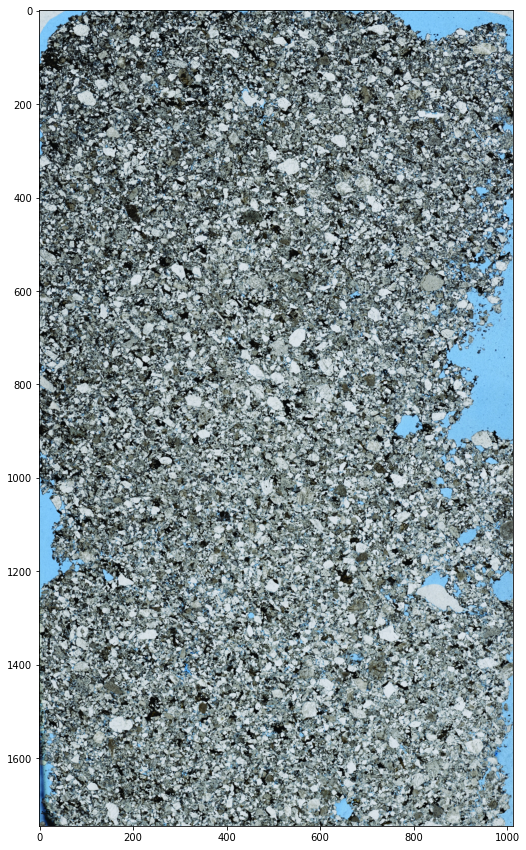

In [18]:
# show image
plt.figure(figsize=(20, 15))
plt.imshow(img_test)

In [19]:
type(img_test)

numpy.ndarray

In [20]:
# load image
pil_img = Image.open(test_path).convert('RGB')
# print image dimensions
print(pil_img.size)

(1014, 1745)


In [106]:
test_img = Image.fromarray(labels)

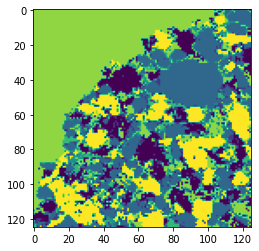

In [114]:
slice = labels.crop([0,0]+[125,125])
plt.imshow(slice)

In [118]:
# slices will be 150 x 150 pixels, so figure out how to slice with those dimensions
# ~30% overlap of each slice
# max number of horizontal slices will be (width-150)//50 

# dimensions for slices
width = 150
height = 150
inc = 50

topleft = [0,0]
botright = [width,height]
# increment for x and y to change topleft and botright values
xinc = inc
yinc = inc
# number of x slices to take and number of y slices to take
xi = (pil_img.size[0]-width)//inc
yi = (pil_img.size[0]-height)//inc

ppl_path = 'Images/ppltest.jpg'
xpl_path = 'Images/xpltest.png'
labels_path = 'Images/labels.png'

# load images
ppl = Image.open(ppl_path).convert('RGB')
xpl = Image.open(xpl_path).convert('RGB')
labels = Image.open(labels_path).convert('RGB')

columns = ['r_ppl','g_ppl','b_ppl', 'r_xpl','g_xpl','b_xpl','labels','rotation','topleft']
# create dataframe to hold the image slices
# columns will be red, blue, green color channels and greyscale value.
df = pd.DataFrame(columns = columns)

In [155]:
def sample_img(df, ppl, xpl, labels, width = 150, height = 150, inc = 50, status = False):
    '''
    Function samples image and stores RGB and greyscale color channels in dataframe.
    Assumed ppl and xpl images are the same size.
    ''' 
    width = width
    height = height
    inc = inc
    
    start = time.time()

    topleft = [0,0]
    botright = [width,height]
    # increment for x and y to change topleft and botright values
    xinc = inc
    yinc = inc
    # number of x slices to take and number of y slices to take
    xi = (ppl.size[0]-width)//inc
    yi = (ppl.size[1]-height)//inc
    
    # dictionary to hold orientations and their pairs
    orientations = {'leftright': Image.FLIP_LEFT_RIGHT,
                   'topbottom': Image.FLIP_TOP_BOTTOM}
    
    # iterate through each sliding window along the height of the image
    for y in np.arange(yi):
        for x in np.arange(xi):
            
            # select orientation of image
            for orientation in [0, 1, 2]:
                if orientation == 0:
                    # isolate a crop of the original images
                    ppl_slice = ppl.crop(topleft+botright)
                    xpl_slice = xpl.crop(topleft+botright)
                    labels_slice = labels.crop(topleft+botright)
                elif orientation == 1:
                    # isolate a crop of the original images
                    ppl_slice = ppl.crop(topleft+botright).transpose(Image.FLIP_LEFT_RIGHT)
                    xpl_slice = xpl.crop(topleft+botright).transpose(Image.FLIP_LEFT_RIGHT)
                    labels_slice = labels.crop(topleft+botright).transpose(Image.FLIP_LEFT_RIGHT)
                else:
                    # isolate a crop of the original images
                    ppl_slice = ppl.crop(topleft+botright).transpose(Image.FLIP_TOP_BOTTOM)
                    xpl_slice = xpl.crop(topleft+botright).transpose(Image.FLIP_TOP_BOTTOM)
                    labels_slice = labels.crop(topleft+botright).transpose(Image.FLIP_TOP_BOTTOM)

                # for each slice, rotate 90 degrees up to 270 to get 4 orientations of each slice
                for rotation in [0, 90, 180, 270]:
                    ppl_slice = ppl_slice.rotate(rotation)
                    xpl_slice = xpl_slice.rotate(rotation)
                    labels_slice = labels_slice.rotate(rotation)
                    # split RGB color channels
                    ppl_red, ppl_green, ppl_blue = ppl_slice.split()
                    xpl_red, xpl_green, xpl_blue = xpl_slice.split()
                    # put all colors into dataframe row
                    df_slice = pd.DataFrame([[np.array(ppl_red), np.array(ppl_green), np.array(ppl_blue), 
                                              np.array(xpl_red), np.array(xpl_green), np.array(xpl_blue),
                                              np.array(labels_slice), rotation, topleft]], columns = columns)
                    #append to main dataframe
                    df = df.append(df_slice, ignore_index = True)
            
            # shift sliding window
            topleft[0] += 100
            botright[0] += 100
            
        # reset sample box to left side of image
        topleft[0] = 0
        botright[0] = width
        # shift sample box down 100 pixels
        topleft[1] += 100
        botright[1] += 100
        
    if status == True:
        end = time.time()
        print(f'Runtime for data collection is {round(end - start,2)} seconds for {len(df)} samples')
    
    return df

def show_img(df, row):
    '''
    Function to display a slice from the dataframe
    '''
    plt.figure(figsize=(10,8))
    plt.subplot(1,3,1)
    plt.imshow(np.dstack((df['r_ppl'][row], df['g_ppl'][row], df['b_ppl'][row])))
    plt.subplot(1,3,2)
    plt.imshow(np.dstack((df['r_xpl'][row], df['g_xpl'][row], df['b_xpl'][row])))
    plt.subplot(1,3,3)
    plt.imshow(df['labels'][row])
    return

def img_quant(img, n_colors=7, plot=False):
    '''Transforms RGB image into a discretized array'''
    original = np.array(img)
    
    # reshape original into one long array with RGB values in lists
    X = original.reshape(-1,3)
    # fit the KMeans clusters
    kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(X)
    
    #assign each pixel to its proper cluster color based on the k-means labels
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    
    # get a list of the unique colors (classes)
    # and re-label the image with discretized values
    # axis=0 so it will consider each list as a unique value
    unique_classes, relabeled_img = np.unique(segmented_img, axis=0, return_inverse=True)
    
    # re-shape to original image dimensions
    segmented_img = segmented_img.reshape(original.shape).astype(np.uint8)
    relabeled_img = relabeled_img.reshape((original.shape[0:2])).astype(np.uint8)
    relabeled_img = Image.fromarray(relabeled_img)
    
    # plot if true
    if plot == True:
        plt.figure(figsize=(10,20))
        plt.subplot(1,2,1)
        plt.imshow(original)
        plt.title('Original image')
        
        plt.subplot(1,2,2)
        plt.imshow(segmented_img)
        plt.title(f'{len(unique_classes)} color clusters')
        
    return relabeled_img

def align_images(df, ppl_img, xpl_img, labels_img, threshold=10, confidence=0.99):
    '''Takes in a dataframe of corresponding points from each image and aligns them using
    a homography matrix. Images just need to be opened with Image.open()'''

    # get pts from df
    ppl_pts = np.array(df['ppl'].tolist())
    xpl_pts = np.array(df['xpl'].tolist())
    labels_pts = np.array(df['labels'].tolist())

    # compute homography matrix between two sets of matched points
    (xpl_H, xpl_mask) = cv2.findHomography(ppl_pts, xpl_pts, cv2.RANSAC, ransacReprojThreshold=threshold, confidence=confidence)
    (labels_H, labels_mask) = cv2.findHomography(ppl_pts, labels_pts, cv2.RANSAC, ransacReprojThreshold=threshold, confidence=confidence)
    
    # use the homography matrix to align the images to the ppl img
    (xpl_h, xpl_w) = ppl_img.shape[:2]
    xpl_aligned = cv2.warpPerspective(xpl_img, xpl_H, (xpl_w,xpl_h))
    
    (labels_h, labels_w) = ppl_img.shape[:2]
    labels_aligned = cv2.warpPerspective(labels_img, labels_H, (labels_w,labels_h))
    

    # resize both the aligned and template images so we can easily 
    # visualize them on the screen
    ppl_aligned = imutils.resize(ppl_img, width=700)
    xpl_aligned = imutils.resize(xpl_aligned, width=700)
    labels_aligned = imutils.resize(labels_aligned, width=700)
    
    plt.imshow(labels_aligned)
    
    ppl = imutils.resize(ppl_img, width=700)
    xpl = imutils.resize(xpl_img, width=700)
    labels = imutils.resize(labels_img, width=700)

    # side-by-side comparison of the output aligned image and the template
    stacked = np.hstack([ppl_aligned, xpl_aligned, labels_aligned])

    # second image alignment visualization will be overlaying the
    # aligned image on the template to get an idea of how good
    # the image alignment is

    template = ppl_aligned.copy()
    xpl_overlay = xpl_aligned.copy()
    labels_overlay = labels_aligned.copy()
    
    print(xpl_overlay.shape)
    print(labels_overlay.shape)
    print(labels.shape)
    
    
    cv2.addWeighted(template, 0.5, xpl_overlay, 0.5, 0, xpl_overlay)
    cv2.addWeighted(template, 0.5, labels_overlay, 0.5, 0, labels_overlay)
    
#     print(labels.shape)
#     print(template.shape)
    
    cv2.addWeighted(template, 0.5, xpl, 0.5, 0, xpl)
    cv2.addWeighted(template, 0.5, labels, 0.5, 0, labels)
    
    # stack overlay imgs next to each other
    overlays_stacked = np.hstack([xpl, labels])
    aligned_overlays_stacked = np.hstack([xpl_overlay, labels_overlay])

    # show the two output inmage alignment visualizations
    plt.figure(figsize=(30,20))

    plt.subplot(3,1,1)
    plt.title('Side-by-side images')
    plt.imshow(stacked)
    
    plt.subplot(3,1,2)
    plt.title('Un-aligned overlayed images')
    plt.imshow(overlays_stacked)

    plt.subplot(3,1,3)
    plt.title('Aligned overlayed images')
    plt.imshow(aligned_overlays_stacked)

    plt.tight_layout()
    
    return overlays_stacked

# Resize Images before alignment

In [195]:
df = pd.read_pickle('resize_pts.pkl')
df.head()

ppl           xpl        labels
0    [271, 165]    [245, 179]    [301, 643]
1  [2965, 5255]  [2984, 5245]  [2860, 5220]

In [225]:
def find_dimensions(df):
    '''Function to find the maximum width of all of the cropped images'''
    width = 0
    for column in df.columns:
        if df[column][1][0]-df[column][0][0] > width:
            width = df[column][1][0]-df[column][0][0]
            height = df[column][1][1]-df[column][0][1]
            
    return height, width

def resize_imgs(df, ppl, xpl, labels, plot=False):
    ''' Load images as cv2.imread(). This will then find the matching crop
    dimensions using find_dimensions and return the new resized and cropped images'''
    ppl = Image.fromarray(ppl)
    xpl = Image.fromarray(xpl)
    labels = Image.fromarray(labels)
    # crop images
    ppl_crop = ppl.crop(df['ppl'][0]+df['ppl'][1])
    xpl_crop = xpl.crop(df['xpl'][0]+df['xpl'][1])
    labels_crop = labels.crop(df['labels'][0]+df['labels'][1])

    # get height and width that you need to resize all images to
    height, width = find_dimensions(df)
    # resize images
    ppl_crop = ppl_crop.resize((width, height))
    xpl_crop = xpl_crop.resize((width, height))
    labels_crop = labels_crop.resize((width, height))
    if plot == True:
        plt.figure(figsize=(15, 20))
        plt.subplot(2,3,1)
        plt.title('Original PPL')
        plt.imshow(ppl)
        plt.subplot(2,3,2)
        plt.title('Original XPL')
        plt.imshow(xpl)
        plt.subplot(2,3,3)
        plt.title('Original Labels')
        plt.imshow(labels)
        # second row cropped images
        plt.subplot(2,3,4)
        plt.title('Cropped PPL')
        plt.imshow(ppl_crop)
        plt.subplot(2,3,5)
        plt.title('Cropped XPL')
        plt.imshow(xpl_crop)
        plt.subplot(2,3,6)
        plt.title('Cropped Labels')
        plt.imshow(labels_crop)
        plt.tight_layout()
    return ppl, xpl, labels

(<PIL.Image.Image image mode=RGB size=3107x5295 at 0x1730926D0>,
 <PIL.Image.Image image mode=RGB size=3136x5305 at 0x171E92BE0>,
 <PIL.Image.Image image mode=RGB size=3415x6357 at 0x188EFEAC0>)

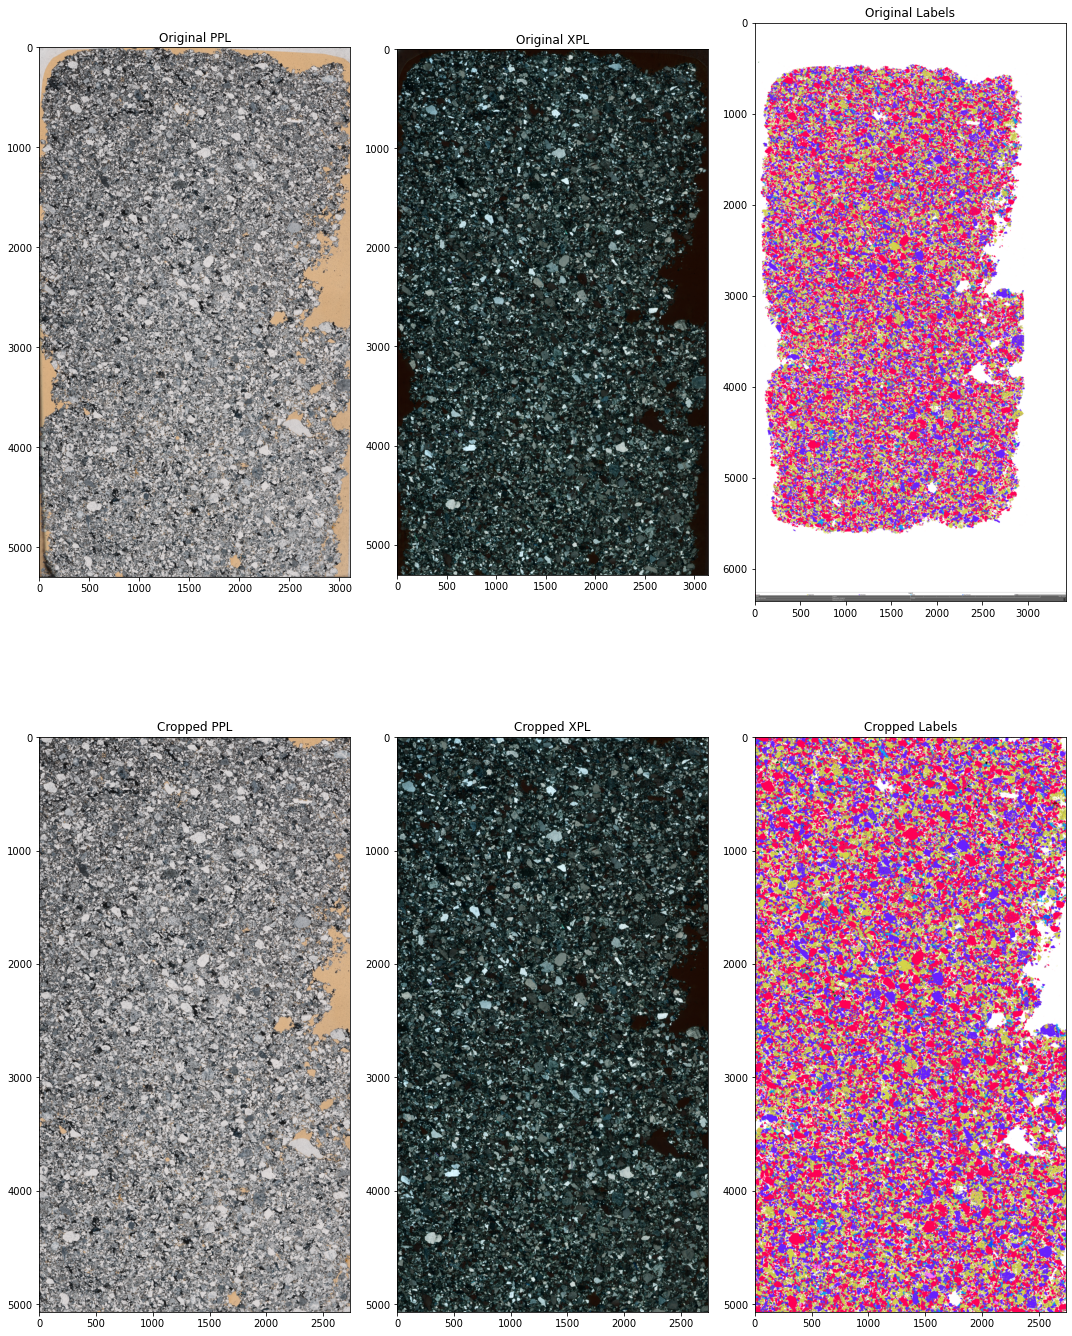

In [226]:
ppl = cv2.imread('Images/EDF-17-1-PPL.jpg')
xpl = cv2.imread('Images/EDF-17-1-CPL.jpg')
labels = cv2.imread('Images/EDF17-1.png')
df = pd.read_pickle('resize_pts.pkl')

ppl, xpl, labels = resize_imgs(df, ppl, xpl, labels, plot=True)

# Align images

ppl          xpl        labels
0   [564, 687]   [560, 687]  [1660, 2375]
1  [172, 1513]  [172, 1513]   [611, 5117]
2   [508, 335]   [506, 338]  [1501, 1438]
3    [78, 181]    [80, 181]   [341, 1033]
4  [874, 1276]  [872, 1282]  [2534, 3957]

error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-39p1qqfs/opencv/modules/imgproc/src/imgwarp.cpp:3392: error: (-215:Assertion failed) src.checkVector(2, CV_32F) == 4 && dst.checkVector(2, CV_32F) == 4 in function 'getPerspectiveTransform'


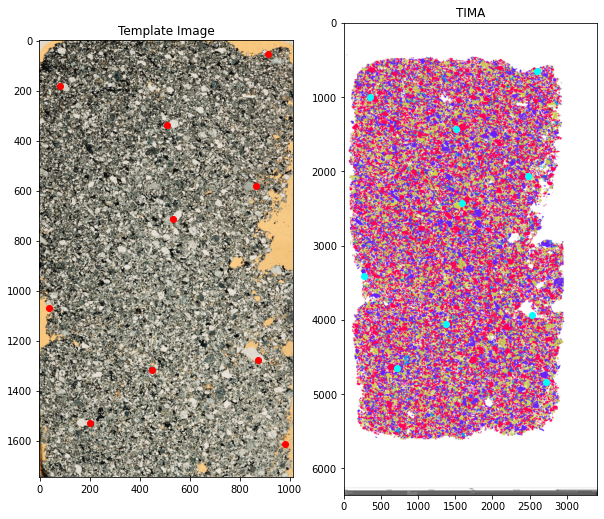

In [193]:
# get pts from df
# ppl_pts = np.array(df['ppl'].tolist())
# labels_pts = np.array(df['labels'].tolist())

ppl_pts = np.array([[866, 580], [874, 1275], [200, 1529], [82, 180], [508, 338],
                   [535, 714], [38, 1069], [449, 1315], [914, 53], [981, 1612]])
labels_pts = np.array([[2482, 2065], [2527, 3938], [716, 4644], [352, 1007], [1511, 1426],
                      [1592, 2433], [266, 3408], [1382, 4056], [2597, 644], [2727, 4841]])

# load and view sample image
ppl_img = cv2.imread('Images/ppltest.jpg')
labels_img = cv2.imread('Images/EDF17-1.png')


plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
plt.imshow(ppl_img)
# plot dots
plt.scatter(ppl_pts[:,0], ppl_pts[:,1], color='r')
plt.title('Template Image')

plt.subplot(1,2,2)
plt.imshow(labels_img)
# plot red dot
plt.scatter(labels_pts[:,0], labels_pts[:,1],color='cyan')
plt.title('TIMA')

# compute homography matrix between two sets of matched points
(labels_H, labels_mask) = cv2.findHomography(ppl_pts, labels_pts, cv2.RANSAC, ransacReprojThreshold=10, confidence=0.99)

# use the homography matrix to align the images to the ppl img
(labels_h, labels_w) = ppl_img.shape[:2]
labels_aligned = cv2.warpPerspective(labels_img, labels_H, (labels_w,labels_h))



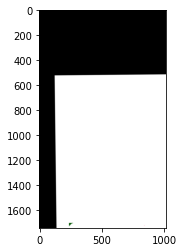

In [192]:
plt.imshow(labels_aligned)

array([[ 866,  580],
       [ 174, 1275],
       [ 200, 1529],
       [  82,  180]])

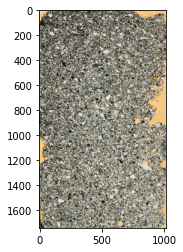

In [166]:
plt.imshow(ppl_img)

(1204, 700, 3)
(1204, 700, 3)
(1303, 700, 3)


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-39p1qqfs/opencv/modules/core/src/arithm.cpp:669: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


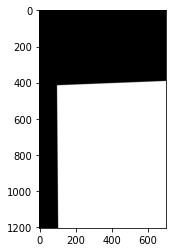

In [156]:
output = align_images(df, ppl, xpl, labels)

In [120]:
df = sample_img(df, ppl, xpl, labels, status=True)

Runtime for data collection is 24.6 seconds for 6324 samples


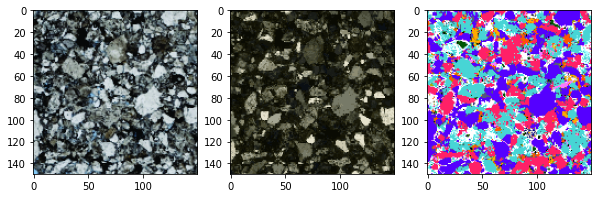

In [123]:
show_img(df, 20)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2108 entries, 0 to 2107
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   r_ppl        2108 non-null   object
 1   g_ppl        2108 non-null   object
 2   b_ppl        2108 non-null   object
 3   r_xpl        2108 non-null   object
 4   g_xpl        2108 non-null   object
 5   b_xpl        2108 non-null   object
 6   orientation  2108 non-null   object
 7   topleft      2108 non-null   object
dtypes: object(8)
memory usage: 131.9+ KB


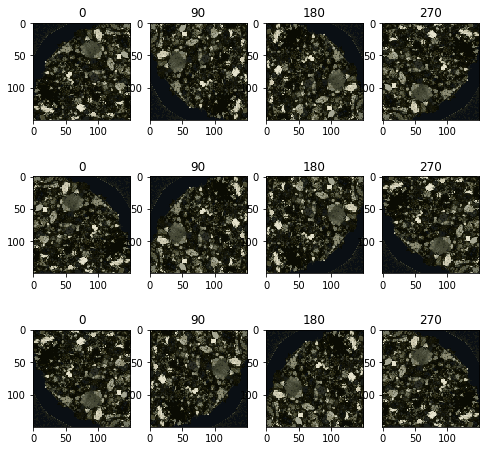

In [59]:
# show all orientations for a single slice
plt.figure(figsize=(8,8))
for i in np.arange(12):
    plt.subplot(3,4,i+1)
    plt.imshow(np.dstack((df['r_xpl'][i], df['g_xpl'][i], df['b_xpl'][i])))
    plt.title(df['rotation'][i])

# Separate colors for classification

In [6]:
# import necessary libraries
from PIL import Image
import numpy as np
from skimage import io
from sklearn.cluster import KMeans

In [7]:
labels_path = 'Images/labels.png'

# load images
labels = Image.open(labels_path).convert('RGB')

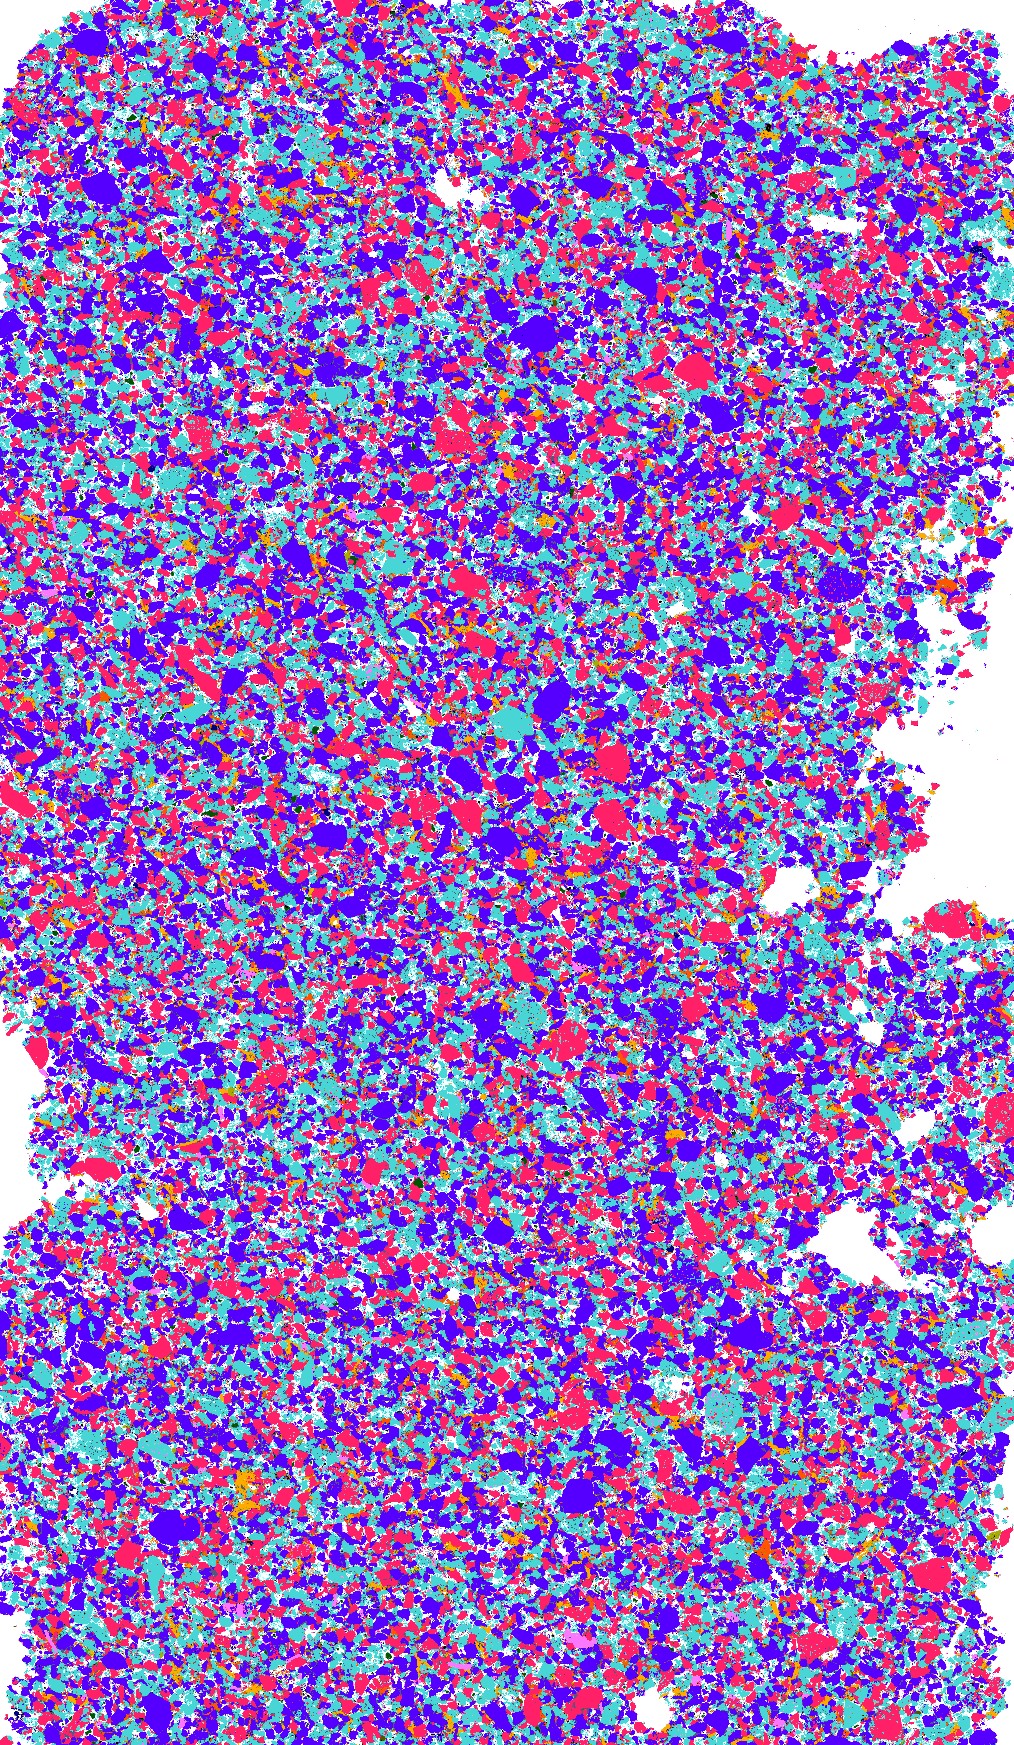

In [8]:
labels

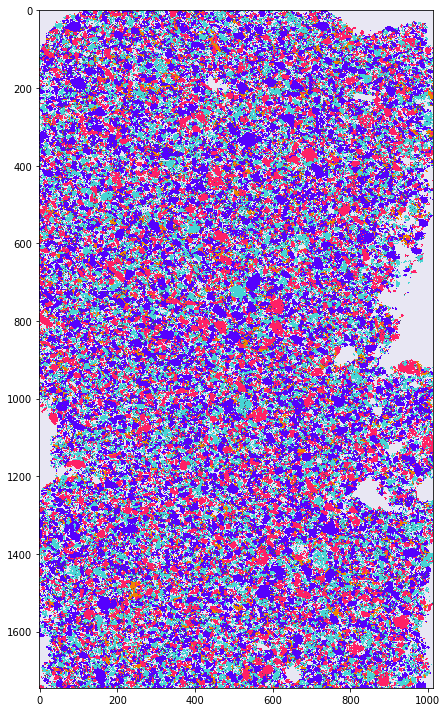

In [66]:
original = Image.open('Images/labels.png').convert('RGB')
original = np.array(original)

n_colors = 6

arr = original.reshape((-1, 3))
kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(arr)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

less_colors = centers[labels].reshape(original.shape).astype('uint8')

plt.figure(figsize=(10,10))
io.imshow(less_colors)

In [31]:
img

NameError: name 'img' is not defined

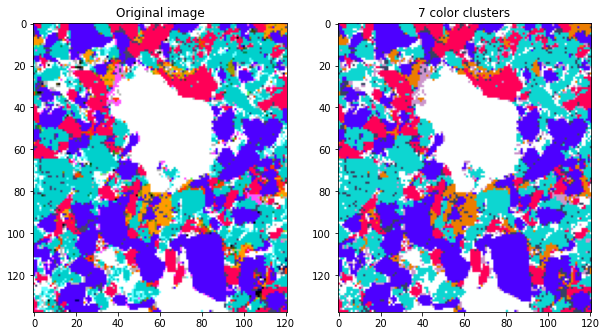

In [38]:
original = Image.open('Images/label_img.png').convert('RGB')

img, labels = img_quant(original, plot=True)



In [36]:
img.shape

(138, 121, 3)

In [41]:
new = labels.reshape((138, 121))

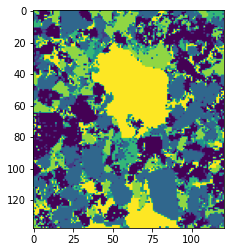

In [42]:
plt.imshow(new)